# Exercise 2
## Céline Budding && Dorothea Müller

# Configurations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eig

%matplotlib inline

from helper import gaussian_spectrum_1D

# 1. Slow Feature Analysis on two independent signals

## 1.

In [2]:
def generate_random_signal(T, e):
    v = np.random.random(T)
    v_filtered = gaussian_spectrum_1D(v, e)
    
    return v_filtered

## 2.

In [3]:
def generate_signals_different_tau(all_tau, T):
    X = np.zeros(shape = (len(all_tau), T))

    for i, tau in enumerate(all_tau):
        eps = 1/tau**2
        signal = generate_random_signal(T, eps)
        # Zero mean.
        signal = signal - np.mean(signal)
        # Unit variance.
        signal /= np.std(signal)
        
        X[i] = signal
        
    return X

In [4]:
T = 1000
all_tau = [30, 100]

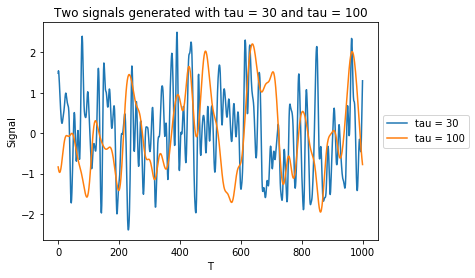

In [5]:
X = generate_signals_different_tau(all_tau, T)

for i, x in enumerate(X):
    plt.plot(x, label = f"tau = {all_tau[i]}")

plt.xlabel("T")
plt.ylabel("Signal")
plt.title('Two signals generated with tau = 30 and tau = 100')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**How does τ influence the characteristics of the signals?**

A higher tau leads to a lower frequency in the data.

## 3. Linear SFA

In [6]:
def calculate_eigvec(X):
    # Joint covariance matrix.
    C = np.cov(X)
    C_derivative = np.diff(X) @ np.diff(X).T / (T-1)
    # C is right-hand side matrix in the generalized eigenvalue problem, so is second parameter.
    eigval, eigvec = eig(C_derivative, C)
    
    return eigvec, eigval

In [7]:
eigvec, _ = calculate_eigvec(X)

The function eig of the scipy package returns already normalized eigenvectors according to the documentation (see returned values in  https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html), so there is no need to normalize.

In [8]:
# To prove the documentation is correct:
for i in range(eigvec.shape[0]):
    print(np.linalg.norm(eigvec[:, i]))

1.0
0.9999999999999999


# 4. 

In [9]:
eigvec

array([[-0.99636703, -0.01912777],
       [ 0.085163  ,  0.99981705]])

**What kind of mixture do you ideally expect given how the data was generated?**

One signal has been generated so it changes more slowly than the other one. As the eigenvectors determine the weight for the linear combination, we expect the eigenvectors to take the slower generated signal more into account.

**What does the empirical mixture look like, judging from the extracted eigenvectors?**

For one eigenvector, we see that there is one large value and one small value, indicating that one signal has a much larger weight than the other. However, the weighting seems reversed for the other eigenvector which might be because the eigenvectors need to be orthogonal.

# TODO
We can see in the eigenvectors that there is one large value and one small value in each of the two vectors, indicating that one of the components has a much larger weight than the other. We cannot determine which of the both it is.

## 5.

In [10]:
sample_sizes = np.logspace(1, 4, num=20)
sample_sizes = [int(s) for s in sample_sizes]

In [11]:
def linear_SFA(sample_sizes, all_tau):
    eigvecs_for_sample_sizes = []
    eigvals_for_sample_sizes = []
    
    for sample_size in sample_sizes:
        X = generate_signals_different_tau(all_tau, sample_size)
        eigvec, eigval = calculate_eigvec(X)
        eigvecs_for_sample_sizes.append(eigvec)
        eigvals_for_sample_sizes.append(eigval)
        
    return eigvecs_for_sample_sizes, eigvals_for_sample_sizes

In [12]:
eigvecs, eigvals = linear_SFA(sample_sizes, all_tau)

In [13]:
print(len(eigvecs))

20


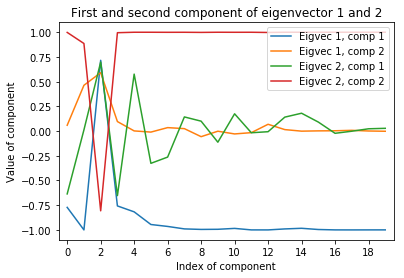

In [14]:
eigvecs = np.array(eigvecs)

plt.plot(eigvecs[:, 0, 0], label = 'Eigvec 1, comp 1')
plt.plot(eigvecs[:, 0, 1], label = 'Eigvec 1, comp 2')
plt.plot(eigvecs[:, 1, 0], label = 'Eigvec 2, comp 1')
plt.plot(eigvecs[:, 1, 1], label = 'Eigvec 2, comp 2')
plt.title("First and second component of eigenvector 1 and 2")
plt.xlabel('Index of component')
plt.ylabel('Value of component')
plt.xticks(np.arange(0, 20, step=2))
plt.xlim(-0.5, 19.5)
plt.legend()
plt.show()

**How does the SFA-mixture change depending on the length of the input signal?**

For larger sample size, the eigenvector components corresponding to the fast signal go to zero which means that there are not mixed into the SFA anymore. However, for small sample sizes they are still taken into account.

**Can you give an intuition why?**

## 6.

In [15]:
eigvals = np.array(eigvals)
# Choose last one to have large sample size and small numerical errors.
eigval = eigvals[-1, :]
eigval

array([0.42917802+0.j, 0.03877677+0.j])

**How do the eigenvalues depend on the τ ’s that you chose?**

The τ = 30 results in a larger eigenvalue than τ = 100. As we are taking eigenvectors that correspond to a small eigenvalue, this is in accordance with the results above.

# 2. SFA on a high-dimensional correlated signal

## 1.

In [16]:
L = 10000
e = 0.04
signal = generate_random_signal(L, e)
len_receptive_field = 100

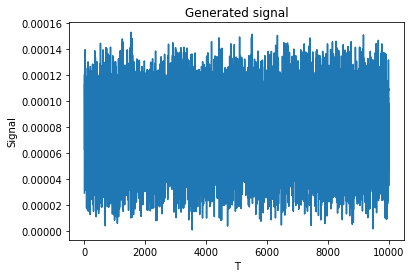

In [17]:
plt.plot(signal)
plt.xlabel('T')
plt.ylabel('Signal')
plt.title('Generated signal')
plt.show()

## 2.

In [18]:
def extract_receptive_fields(stimulus, len_receptive_field):
    number_fields = len(stimulus) - len_receptive_field
    all_rec_fields = np.zeros(shape = (number_fields, len_receptive_field))
    
    for i in range(number_fields):
        all_rec_fields[i] = stimulus[i:len_receptive_field+i]
    
    # Enforce zero mean across each field.
    all_rec_fields -= np.mean(all_rec_fields.T, axis = 1)
    all_rec_fields = all_rec_fields.T
    print(all_rec_fields.shape)
    
    return all_rec_fields

In [19]:
X = extract_receptive_fields(signal, len_receptive_field)

(100, 9900)


## 3.

In [20]:
### TMP
# Joint covariance matrix.
C = np.cov(X)
X_dot = np.diff(X, axis = 1)
C_derivative = X_dot @ X_dot.T / (L-1)
# C is right-hand side matrix in the generalized eigenvalue problem, so is second parameter.
eigval, eigvec = eig(C_derivative, C)

In [21]:
# Sort in ascending order.
idx = np.argsort(np.abs(eigval))
eigvec = eigvec[:, idx]
eigval = eigval[idx]

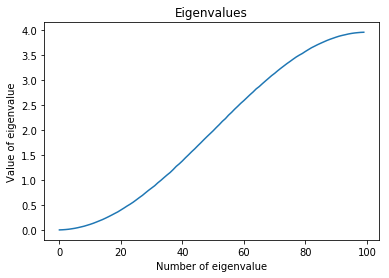

In [22]:
plt.plot(eigval.real)
plt.xlabel('Number of eigenvalue')
plt.ylabel('Value of eigenvalue')
plt.title('Eigenvalues')
plt.show()

In [23]:
# Select the first five smallest eigenvectors
five_eigvec = eigvec[:, :5]
five_eigvec.shape

(100, 5)

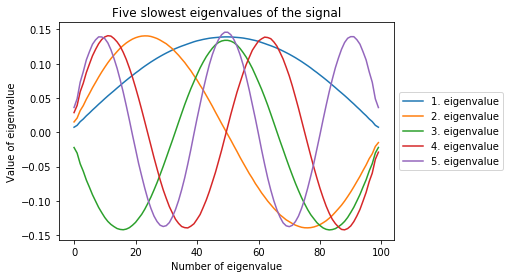

In [24]:
for i, eig_vec in enumerate(five_eigvec.T): 
    plt.plot(eig_vec, label = '{}. eigenvalue'.format(i+1))
plt.xlabel('Number of eigenvalue')
plt.ylabel('Value of eigenvalue')
plt.title('Five slowest eigenvalues of the signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 5. 

**How do you interpret the shape of the eigenvectors?**
The eigenvectors are periodic and they remind us of a sinusoidal grating.

**In which way do the characteristics of the eigenvectors correspond to the intentions underlying SFA?**
We do want to have only small changes regarding g(x). 

**Discuss the properties of the eigenvectors at the boundaries of the receptive fields (Hint: think about how these boundaries react when sliding over edges in the image).**
We would expect the eigenvectors close to 0.

**How does the shape of these eigenvectors relate to the structure of the receptive fields in primary visual cortex V1?**

## 6.

In [25]:
y = five_eigvec.T @ X

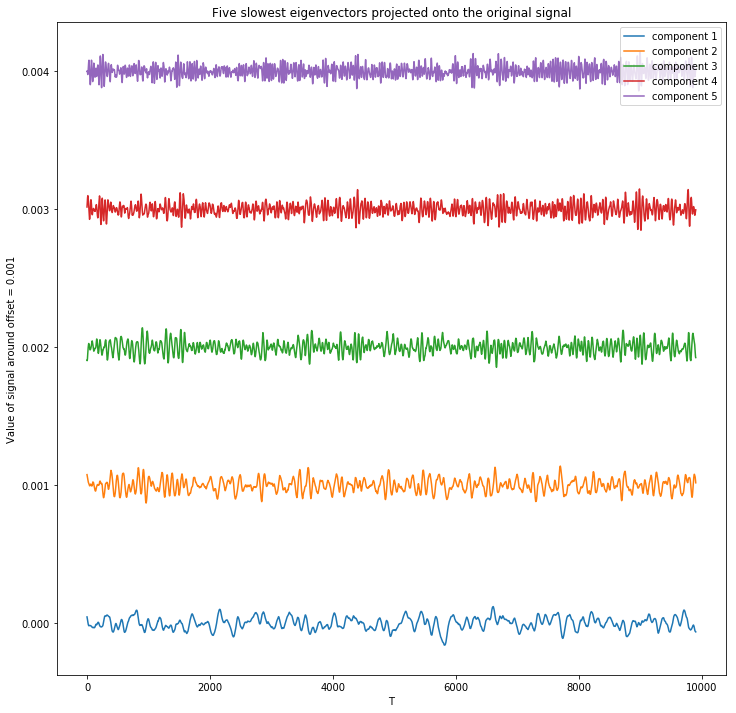

In [26]:
offset = 0.001
plt.figure(figsize = (12,12))
for i, y_ in enumerate(y):
    plt.plot(y_ + i * offset, label = f"component {i + 1}")

plt.xlabel('T')
plt.ylabel('Value of signal around offset = 0.001')
plt.title('Five slowest eigenvectors projected onto the original signal')
plt.legend()
plt.show()

**Did the *Slow* Feature Analysis succeed?**

The components do not change over time, so it would suggest that it worked.